In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import geonamescache
import sklearn
from pandas.plotting import scatter_matrix



In [2]:
suicides_data = pd.read_csv('SuicideRatesData.csv')

In [3]:
suicides_data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [4]:

data = suicides_data.drop(['HDI for year'], axis = 1)

# Countries removed where data is avalable for less than 10 years only
by_countryYear = data.groupby('country')['year'].nunique().reset_index()
countries = list(by_countryYear[by_countryYear['year']>=10]['country'])
data = data[data['country'].isin(countries)]

# Mapped Continent to countries
gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
mapping = pd.DataFrame(countries).T.reset_index()[['name','continentcode']]
mapping.rename(columns = {'name':'country'}, inplace=True)
mapping['country'] = mapping['country'].replace({'Macao':'Macau',
                                   'Czechia':'Czech Republic',
                                   'South Korea':'Republic of Korea',
                                   'Russia':'Russian Federation',
                                   'Saint Vincent and the Grenadines':'Saint Vincent and Grenadines'})

data = pd.merge(data,mapping,on='country', how = 'left')
data['continentcode'] = data['continentcode'].replace({'EU':'Europe',
                                   'AS':'Asia',
                                   'NA':'North America',
                                   'SA':'South America',
                                   'AF':'Africa',
                                   'OC':'Oceania'})

# converting columns to catgegory data type
data['continentcode'] = pd.Categorical(data['continentcode'])
data['age'] = pd.Categorical(data['age'])
data['age'].cat.reorder_categories(['5-14 years','15-24 years','25-34 years',
                                    '35-54 years','55-74 years','75+ years'], inplace = True)
data['generation'] = pd.Categorical(data['generation'])
data['generation'].cat.reorder_categories(['G.I. Generation','Silent','Boomers','Generation X','Millenials','Generation Z'],
                                          inplace = True)
data['country'] = pd.Categorical(data['country'])
data['sex'] = pd.Categorical(data['sex'])
data.rename(columns = {'continentcode':'continent'},inplace = True)

# data for year 2016 is removed due to very less observations 
#data.pivot_table(values = 'suicides_no',index = 'country',columns = 'year',aggfunc='sum').isnull().sum()
data = data[data['year'] != 2016]

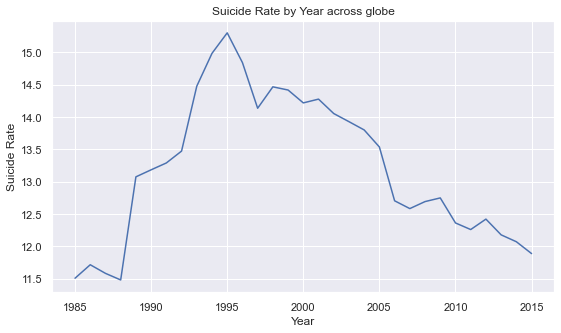

In [5]:
plt.figure(figsize=(9,5))
by_year = data.groupby(['year'])[['population','suicides_no']].sum().reset_index()
by_year['suicide_rate'] = by_year['suicides_no']*100000/by_year['population']
ax = sns.lineplot(x="year", y="suicide_rate",data=by_year)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by Year across globe')
plt.show()

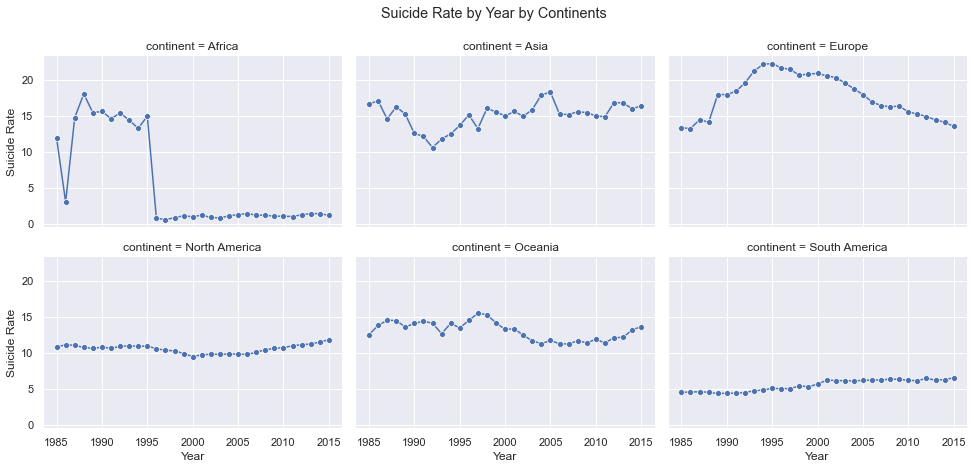

In [6]:
by_continent = data.groupby(['continent','year'])[['population','suicides_no']].sum().reset_index()
by_continent['suicide_rate'] = by_continent['suicides_no']*100000/by_continent['population']
sns.set_style("darkgrid")
ax = sns.relplot(x="year", y="suicide_rate", col="continent",col_wrap=3,
                 data=by_continent , kind="line", legend="full", marker='o',
                height=3, aspect=1.5)
ax.set(ylabel='Suicide Rate', xlabel='Year')
ax.fig.suptitle('Suicide Rate by Year by Continents', x=0.5, y=1.05)
plt.show()

In [7]:
dm = data.groupby(['country','year'])['suicides_no','population'].sum().reset_index()
dm['suicide_rate'] = dm['suicides_no']*100000/dm['population']
dm = dm[dm['suicides_no'].notnull()]
from sklearn.linear_model import LinearRegression
b = []
for country in dm.country.unique():
    tempdf = dm[dm['country'] == country]
    X = np.asarray(tempdf['year']).reshape([-1,1])
    y = np.asarray(tempdf['suicide_rate']).reshape([-1,1])
    model = LinearRegression()
    results = model.fit(X,y).coef_[0][0]
    b.append([country,results])

df = pd.DataFrame(b,columns=['country','factor']).sort_values(by='factor')
decrease = list(df['country'].head(5))
increase = list(df['country'].tail(5))

<ipython-input-7-b0019ed73f69>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dm = data.groupby(['country','year'])['suicides_no','population'].sum().reset_index()


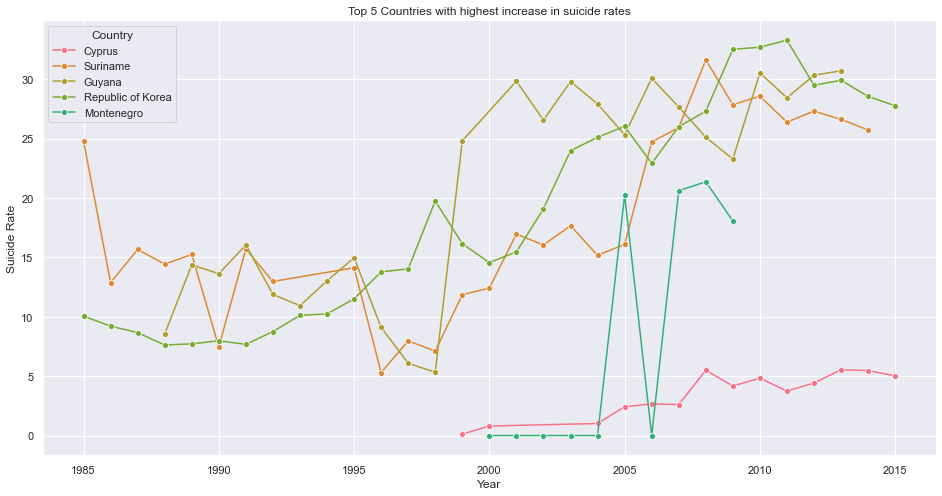

In [8]:
plt.figure(figsize=(16,8))
leg = []
sns.set_palette("husl", 10)
for country in increase:
    dm_country = dm[dm['country'] == country]
    ax = sns.lineplot(x="year", y="suicide_rate",data=dm_country, marker='o')
    leg.append(country)

plt.legend(title='Country', loc='best', labels=leg)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Top 5 Countries with highest increase in suicide rates')
plt.show()

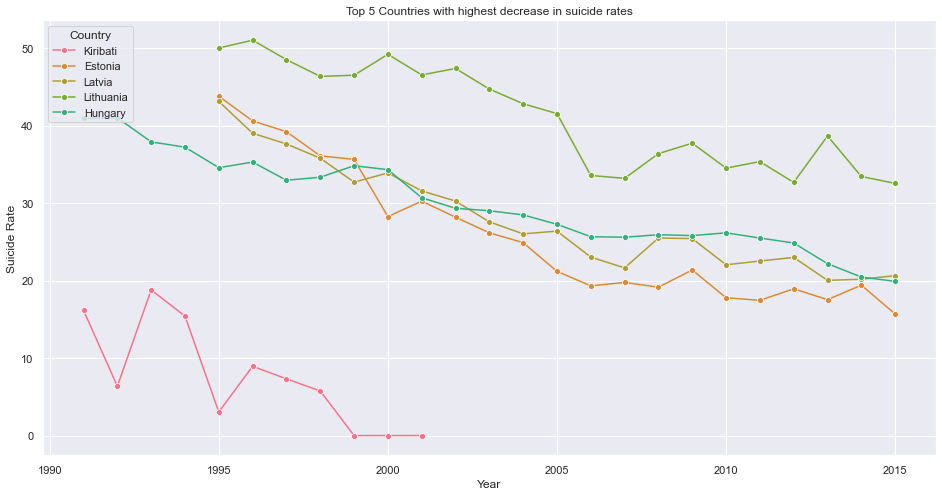

In [9]:
plt.figure(figsize=(16,8))
leg = []
sns.set_palette("husl", 10)
for country in decrease:
    dm_country = dm[dm['country'] == country]
    ax = sns.lineplot(x="year", y="suicide_rate",data=dm_country, marker='o')
    leg.append(country)

plt.legend(title='Country', loc='upper left', labels=leg)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Top 5 Countries with highest decrease in suicide rates')
plt.show()

,gdp_per_capita ($),suicide_rate
gdp_per_capita ($),1.000000,0.088597
suicide_rate,0.088597,1.000000


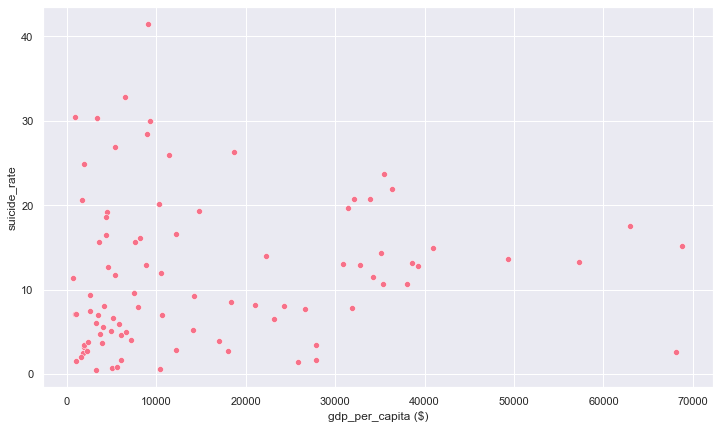

In [10]:
by_gdp_country = data.groupby(['country']).agg({'population':'sum', 
                         'suicides_no':'sum', 
                         'gdp_per_capita ($)':'mean'}).reset_index()
by_gdp_country['suicide_rate'] = by_gdp_country['suicides_no']*100000/by_gdp_country['population']
plt.figure(figsize=(12,7))
sns.scatterplot(x="gdp_per_capita ($)", y="suicide_rate", data=by_gdp_country)
by_gdp_country[['gdp_per_capita ($)','suicide_rate']].corr()

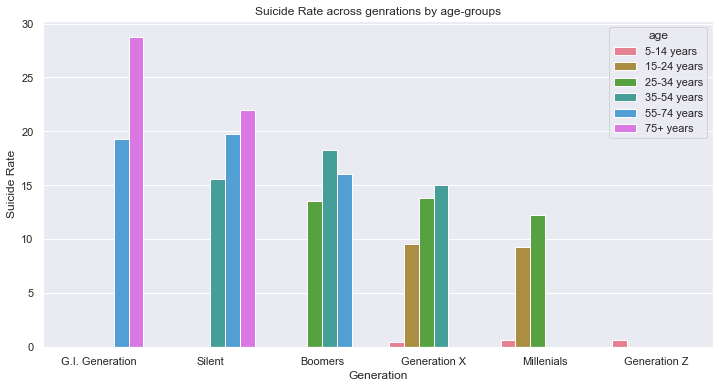

In [11]:
age_gen_suicideno = data.pivot_table(values = 'suicides_no',index = 'generation',columns = 'age',aggfunc='sum')
age_gen_population = data.pivot_table(values = 'population',index = 'generation',columns = 'age',aggfunc='sum')
by_age_gen = age_gen_suicideno*100000/age_gen_population
by_age_gen = by_age_gen.stack().reset_index(name='suicide_rate')
plt.figure(figsize=(12,6))
sns.set_palette("husl", 6)
ax = sns.barplot(x = 'generation',y = 'suicide_rate', hue='age',data=by_age_gen)
ax.legend(loc =1, title = 'age')
ax.set(ylabel='Suicide Rate', xlabel='Generation', title = 'Suicide Rate across genrations by age-groups')
plt.show()

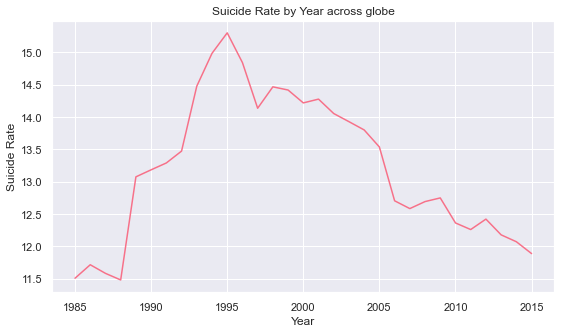

In [12]:
plt.figure(figsize=(9,5))
by_year = data.groupby(['year'])[['population','suicides_no']].sum().reset_index()
by_year['suicide_rate'] = by_year['suicides_no']*100000/by_year['population']
ax = sns.lineplot(x="year", y="suicide_rate",data=by_year)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by Year across globe')
plt.show()

In [13]:
data.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', ' gdp_for_year ($) ',
       'gdp_per_capita ($)', 'generation', 'continent'],
      dtype='object')

In [14]:
data.columns = ['country', 'year', 'gender', 'age_group', 'suicide_count', 'population', 'suicide_rate', 'country-year', 'HDI for year',
                'gdp_for_year', 'gdp_per_capita', 'generation']

In [15]:
data = data.drop(['HDI for year'], axis = 1)
data.shape

(27264, 11)

In [16]:
data = data.drop(['country-year'], axis = 1)
data.shape

(27264, 10)

In [17]:
data = data.dropna()
data.shape

(27264, 10)

In [18]:
#encoding the categorical features with LabelEncoder

from sklearn.preprocessing import LabelEncoder
categorical = ['country', 'year','age_group', 'gender', 'generation']
le = sklearn.preprocessing.LabelEncoder()

for column in categorical:
    data[column] = le.fit_transform(data[column])

In [19]:
#creating a copy of dataset for statistical test

stat_data = data.copy()
stat_data

,country,year,gender,age_group,suicide_count,population,suicide_rate,gdp_for_year,gdp_per_capita,generation
0,0,2,1,0,21,312900,6.71,796,Generation X,2
1,0,2,1,2,16,308000,5.19,796,Silent,2
2,0,2,0,0,14,289700,4.83,796,Generation X,2
3,0,2,1,5,1,21800,4.59,796,G.I. Generation,2
4,0,2,1,1,9,274300,3.28,796,Boomers,2
...,...,...,...,...,...,...,...,...,...,...
27409,89,29,0,2,107,3620833,2.96,2309,Generation X,1
27410,89,29,0,5,9,348465,2.58,2309,Silent,1
27411,89,29,1,3,60,2762158,2.17,2309,Generation Z,1
27412,89,29,0,3,44,2631600,1.67,2309,Generation Z,1


In [20]:
data.dtypes

country              int32
year                 int64
gender               int32
age_group            int32
suicide_count        int64
population           int64
suicide_rate       float64
gdp_for_year         int64
gdp_per_capita    category
generation           int32
dtype: object

In [21]:
# Converting the column 'gdp_for_year' to float from object

data['gdp_for_year'] = data['gdp_for_year'].str.replace(',','').astype(float)

AttributeError: Can only use .str accessor with string values!

In [ ]:
#Scaling the numerical data columns with RobustScalar

numerical = ['suicide_count', 'population', 'suicide_rate', 
              'gdp_for_year','gdp_per_capita']

from sklearn.preprocessing import RobustScaler

rc = RobustScaler()
data[numerical] = rc.fit_transform(data[numerical])

In [ ]:
# Sepratating & assigning features and target columns to X & y

y = data['suicide_rate']
X = data.drop('suicide_rate',axis=1)
X.shape, y.shape

In [ ]:
# Splitting the dataset into train and test sets: 80-20 split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)
X_train.shape, X_test.shape

In [ ]:
#importing required libraries 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [ ]:
# Creating holders to store the model performance results
ML_Model = []
acc_train = []
acc_test = []
rmse_train = []
rmse_test = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    acc_train.append(round(a, 3))
    acc_test.append(round(b, 3))
    rmse_train.append(round(c, 3))
    rmse_test.append(round(d, 3))

In [ ]:
#Decision Tree regression model 
from sklearn.tree import DecisionTreeRegressor

# instantiate the model 
tree = DecisionTreeRegressor(max_depth=9)
# fit the model 
tree.fit(X_train, y_train)

In [ ]:
#predicting the target value from the model for the samples
y_test_tree = tree.predict(X_test)
y_train_tree = tree.predict(X_train)

In [ ]:
#computing the accuracy of the model performance
acc_train_tree = tree.score(X_train, y_train)
acc_test_tree = tree.score(X_test, y_test)

#computing root mean squared error (RMSE)
rmse_train_tree = np.sqrt(mean_squared_error(y_train, y_train_tree))
rmse_test_tree = np.sqrt(mean_squared_error(y_test, y_test_tree))

print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree))
print('\nDecision Tree: The RMSE of the training set is:', rmse_train_tree)
print('Decision Tree: The RMSE of the testing set is:', rmse_test_tree)

In [ ]:
training_accuracy = []
test_accuracy = []
# try max_depth from 1 to 30
depth = range(1, 31)
for n in depth:
    # fit the model
    tree = DecisionTreeRegressor(max_depth=n)
    tree.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(tree.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(tree.score(X_test, y_test))

#plotting the training & testing accuracy for max_depth from 1 to 30
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("max_depth")
plt.legend()